# Scanpy: Quality control

#DATA_TITLE:

#DATA_ALL1:


In [7]:
# create a data directory.
!mkdir -p data/raw



#DATA_ALL2:

In [8]:
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# gives error!! sc.logging.print_versions()


In [9]:
sc.settings.set_figure_params(dpi=80)

#DATA_ALL3:

In [10]:
data_cov1 = sc.read_10x_h5('./data/raw/nCoV_PBMC_1.h5')
data_cov1.var_names_make_unique()
data_cov15 = sc.read_10x_h5('./data/raw/nCoV_PBMC_15.h5')
data_cov15.var_names_make_unique()
data_cov17 = sc.read_10x_h5('./data/raw/nCoV_PBMC_17.h5')
data_cov17.var_names_make_unique()
data_ctrl5 = sc.read_10x_h5('./data/raw/Normal_PBMC_5.h5')
data_ctrl5.var_names_make_unique()
data_ctrl13 = sc.read_10x_h5('./data/raw/Normal_PBMC_13.h5')
data_ctrl13.var_names_make_unique()
data_ctrl14 = sc.read_10x_h5('./data/raw/Normal_PBMC_14.h5')
data_ctrl14.var_names_make_unique()

reading ./data/raw/nCoV_PBMC_1.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/nCoV_PBMC_15.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/nCoV_PBMC_17.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_13.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_14.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#OBJ_TITLE:

In [11]:
# add some metadata
data_cov1.obs['type']="Covid"
data_cov1.obs['sample']="covid_1"
data_cov15.obs['type']="Covid"
data_cov15.obs['sample']="covid_15"
data_cov17.obs['type']="Covid"
data_cov17.obs['sample']="covid_17"
data_ctrl5.obs['type']="Ctrl"
data_ctrl5.obs['sample']="ctrl_5"
data_ctrl13.obs['type']="Ctrl"
data_ctrl13.obs['sample']="ctrl_13"
data_ctrl14.obs['type']="Ctrl"
data_ctrl14.obs['sample']="ctrl_14"


# merge into one object.
adata = data_cov1.concatenate(data_cov15, data_cov17, data_ctrl5, data_ctrl13, data_ctrl14)

# and delete individual datasets to save space
del(data_cov1, data_cov15, data_cov17)
del(data_ctrl5, data_ctrl13, data_ctrl14)



#OBJ_SCRANPY:

In [12]:
print(adata.obs['sample'].value_counts())

adata

covid_17    1500
ctrl_14     1500
covid_1     1500
covid_15    1500
ctrl_5      1500
ctrl_13     1500
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

#QC_TITLE:

#QC_ALL1:

#QC_ALL1.1:

#QC_1_SCANPY:


In [13]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

,gene_ids,feature_types,genome,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False
...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,False,False
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,False,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,False,False
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,False,False


In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)


#QC_2_SCANPY:

In [15]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1



#QC_2_SCANPY:

In [16]:
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#QC_TITLE2:

#QC_ALL3:

... storing 'type' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg

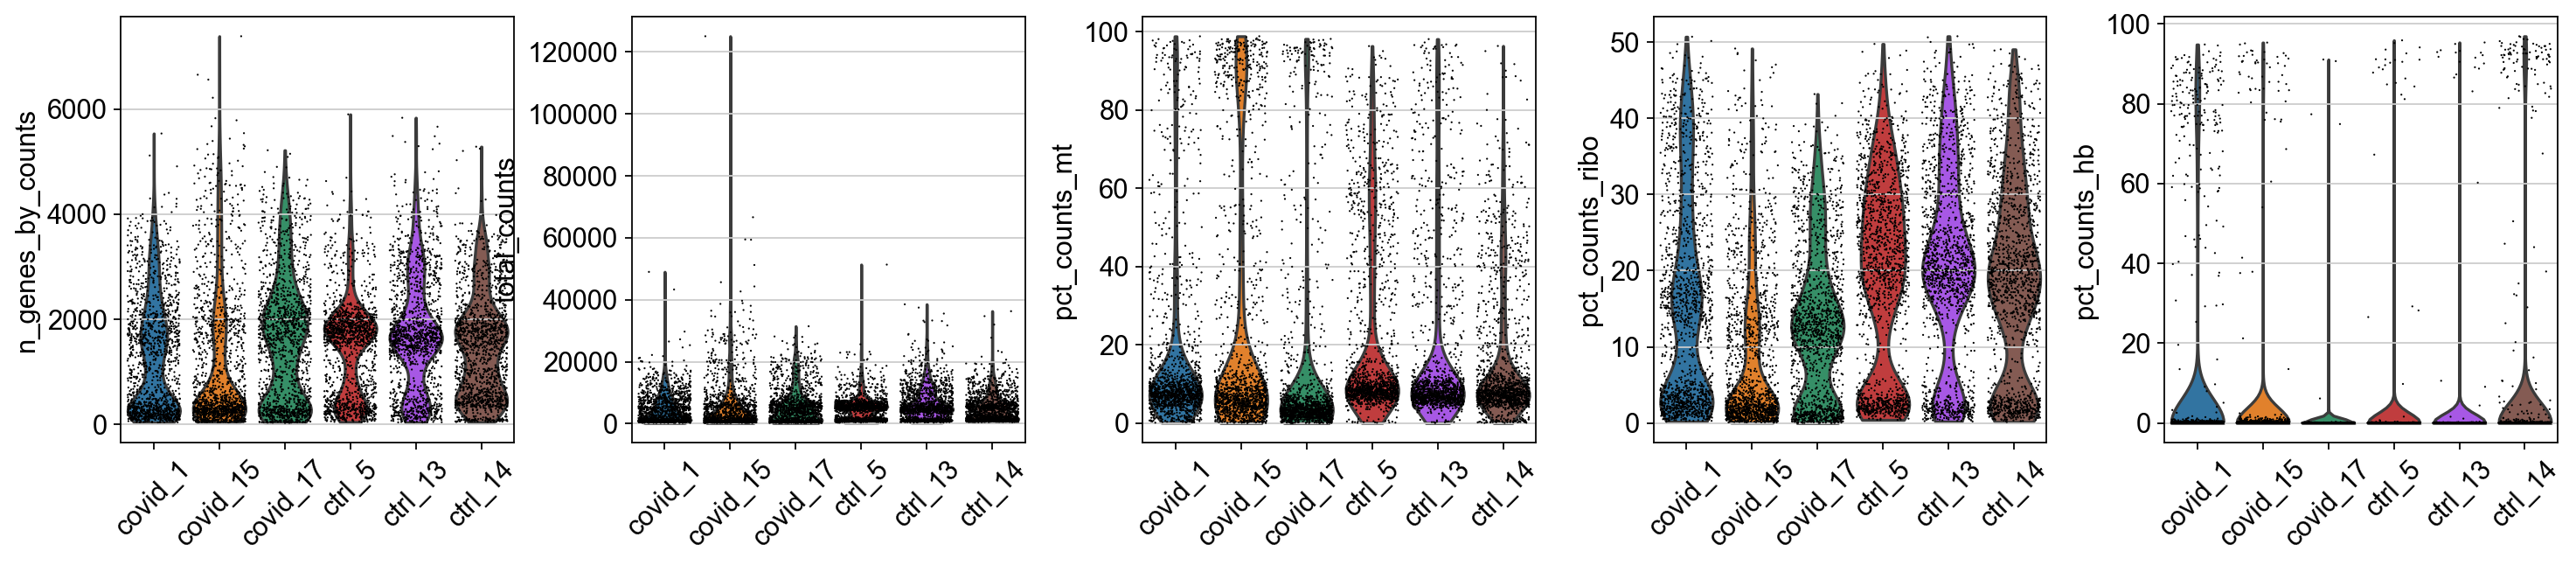

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

#QC_ALL4:


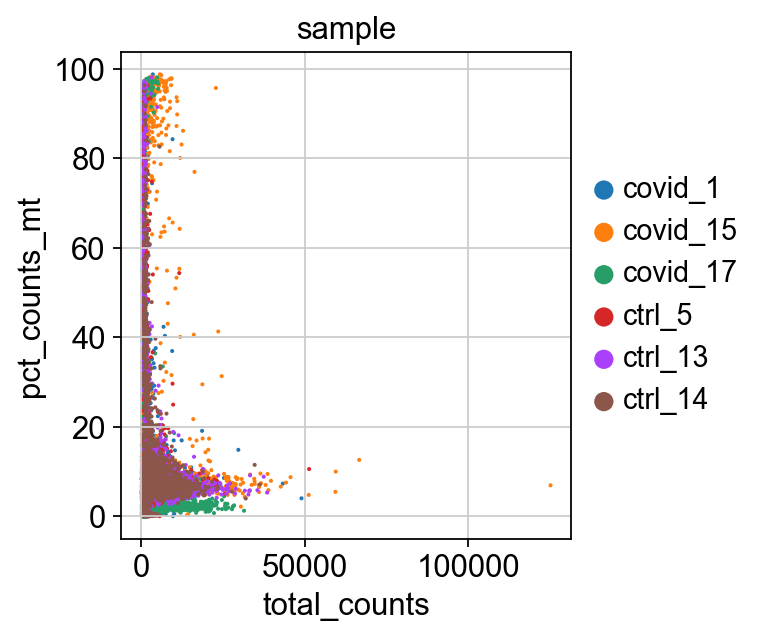

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")


#QC_ALL4.4:

#FILTERING_TITLE:

#FILTERING_ALL0:


In [19]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1021 cells that have less than 200 genes expressed
filtered out 14760 genes that are detected in less than 3 cells
7979 18778


#FILTERING_ALL3:

In [20]:
# skip for now as we are doing doublet prediction
#keep_v2 = (adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['n_genes_by_counts'] > 500) & (adata.obs['lib_prep'] == 'v2')
#print(sum(keep_v2))

# filter for gene detection for v3
#keep_v3 = (adata.obs['n_genes_by_counts'] < 4100) & (adata.obs['n_genes_by_counts'] > 1000) & (adata.obs['lib_prep'] != 'v2')
#print(sum(keep_v3))

# keep both sets of cells
#keep = (keep_v2) | (keep_v3)
#print(sum(keep))
#adata = adata[keep, :]

#print("Remaining cells %d"%adata.n_obs)

#FILTERING_ALL01:


normalizing counts per cell
    finished (0:00:00)


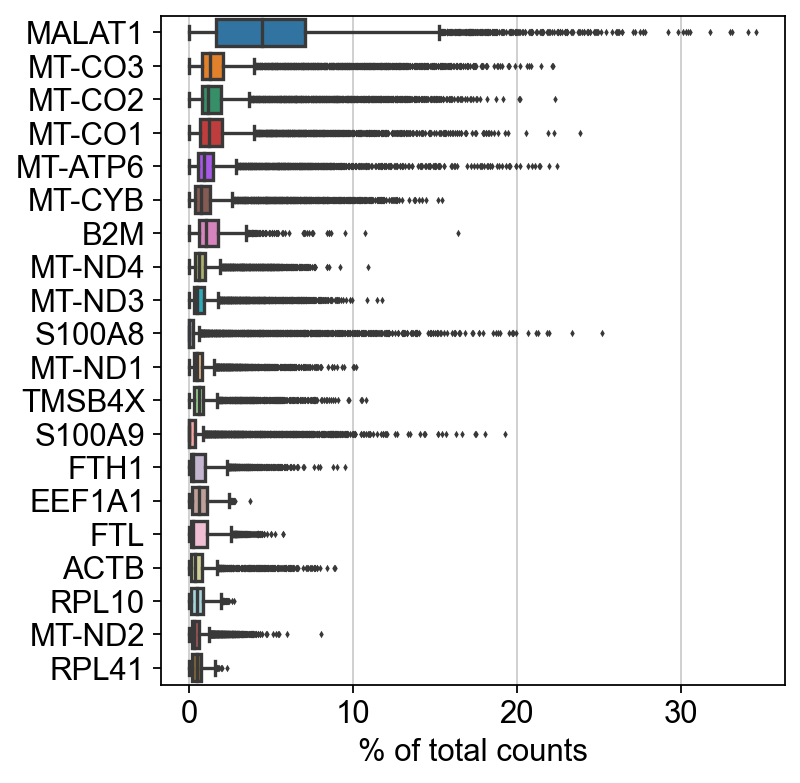

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20)

#FILTERING_ALL02:

#FILTERING_TITLE2:

#FILTERING_ALL1:

In [22]:
# filter for percent mito


adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 5762


#FILTERING_ALL2:

#FILTERING_TITLE4:

#FILTERING_ALL5:

/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

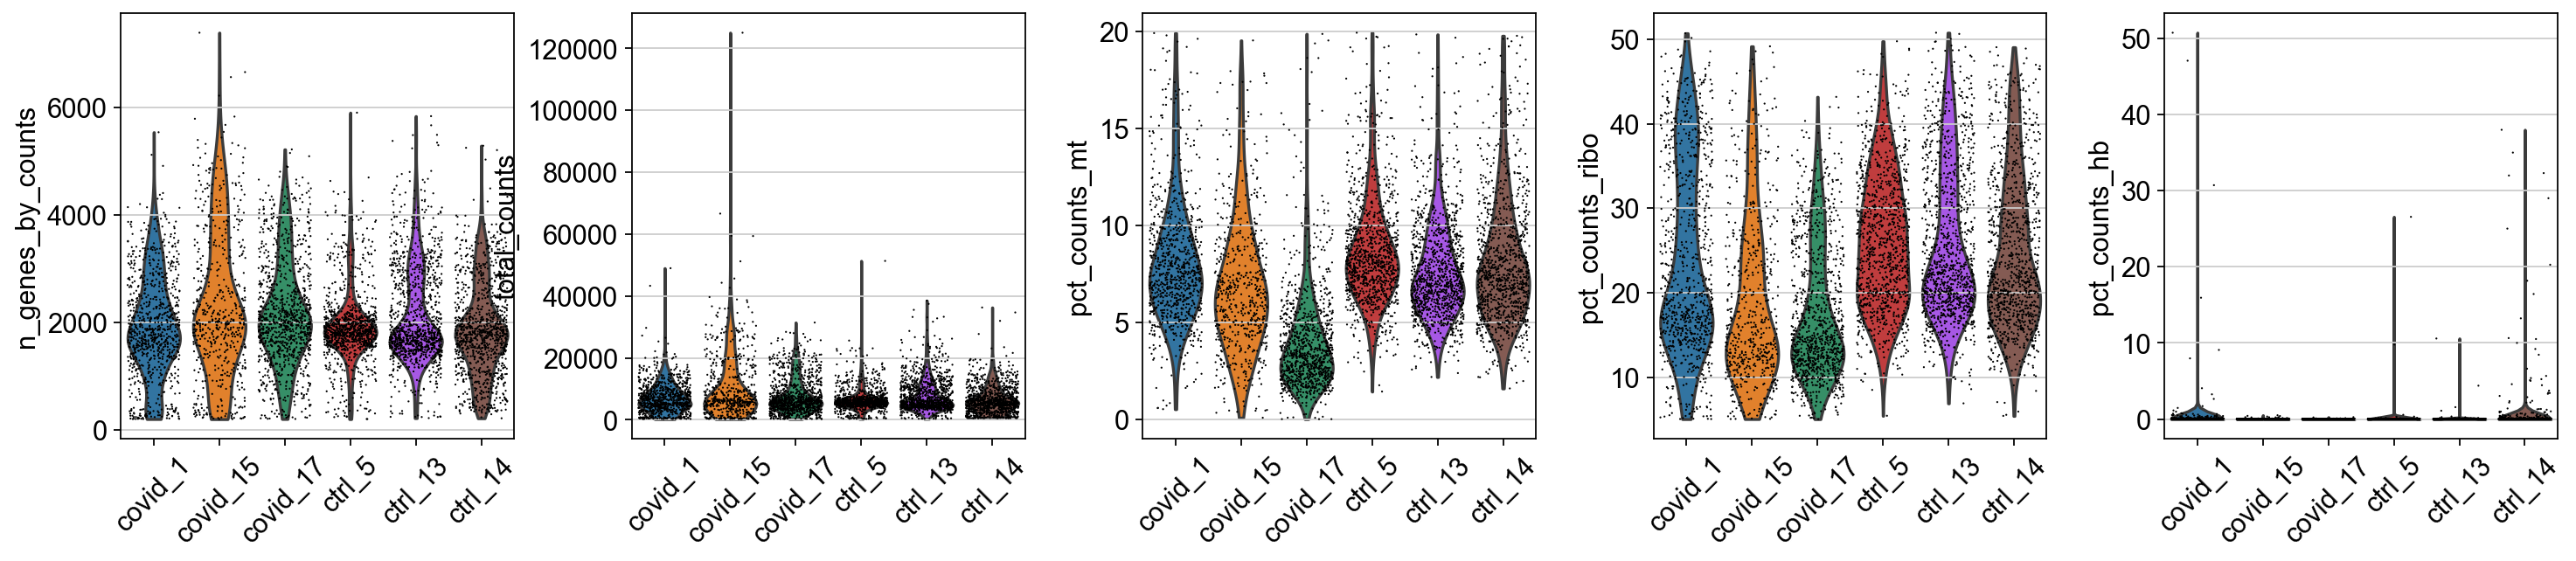

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation = 45)

#FILTERING_TITLE5:

#FILTERING_ALL6:

In [24]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

5762 18752


#SEX_TITLE:

#SEX_ALL1:

To get choromosome information for all genes, you should ideally parse the information from the gtf file that you used in the mapping pipeline as it has the exact same annotation version/gene naming. However, it may not always be available, as in this case where we have downloaded public data. Hence, we will use biomart to fetch chromosome information.

In [29]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")
#>>> adata.var[annot.columns] = annot

#SEX_ALL3:

In [35]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['RPS4Y1', 'AC006157.1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'PCDH11Y',
       'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'NLGN4Y', 'TTTY14', 'AC010889.1',
       'KDM5D', 'EIF1AY', 'RPS4Y2'],
      dtype='object')

In [54]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

#SEX_ALL4:

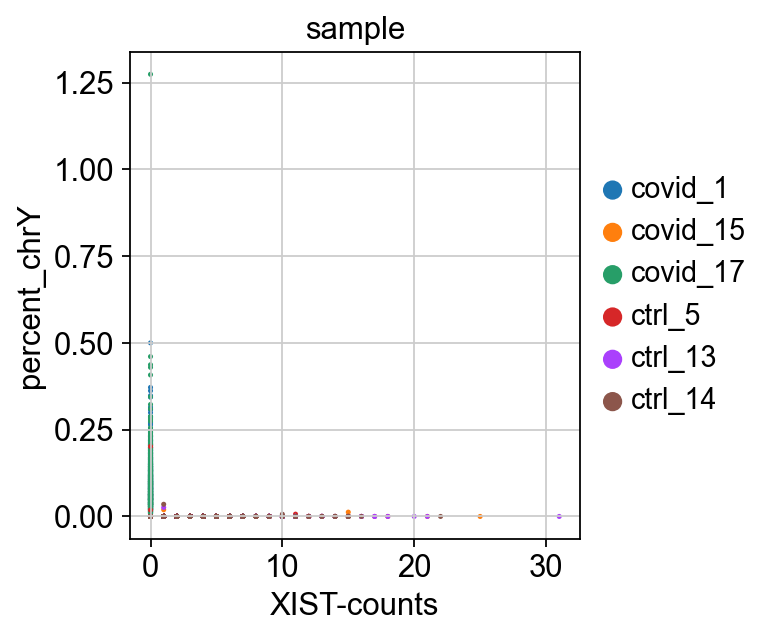

In [61]:
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")


#SEX_ALL5:

/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

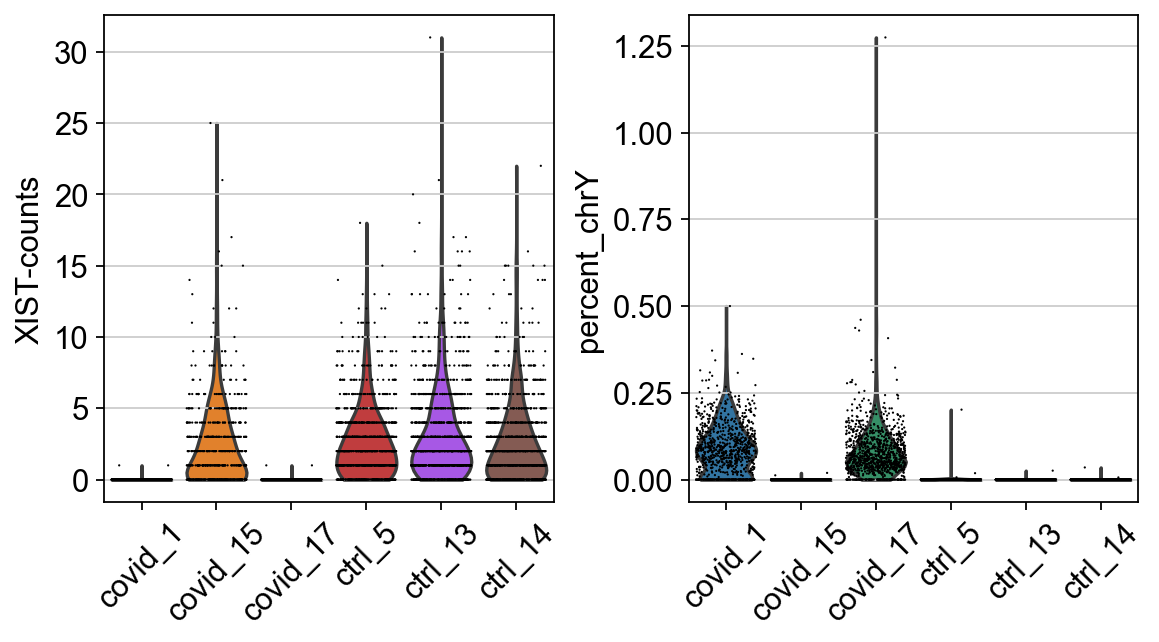

In [60]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby = 'sample', rotation= 45)

#SEX_ALL6:

#CELLCYCLE_TITLE:

#CELLCYCLE_ALL1:

#CELLCYCLE_1_SCANPY:


In [19]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi
    

In [20]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


#CELLCYCLE_2_SCANPY: 

In [21]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


#CELLCYCLE_3_SCANPY: 

In [22]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    729 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    772 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


#CELLCYCLE_ALL2:

... storing 'phase' as categorical
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

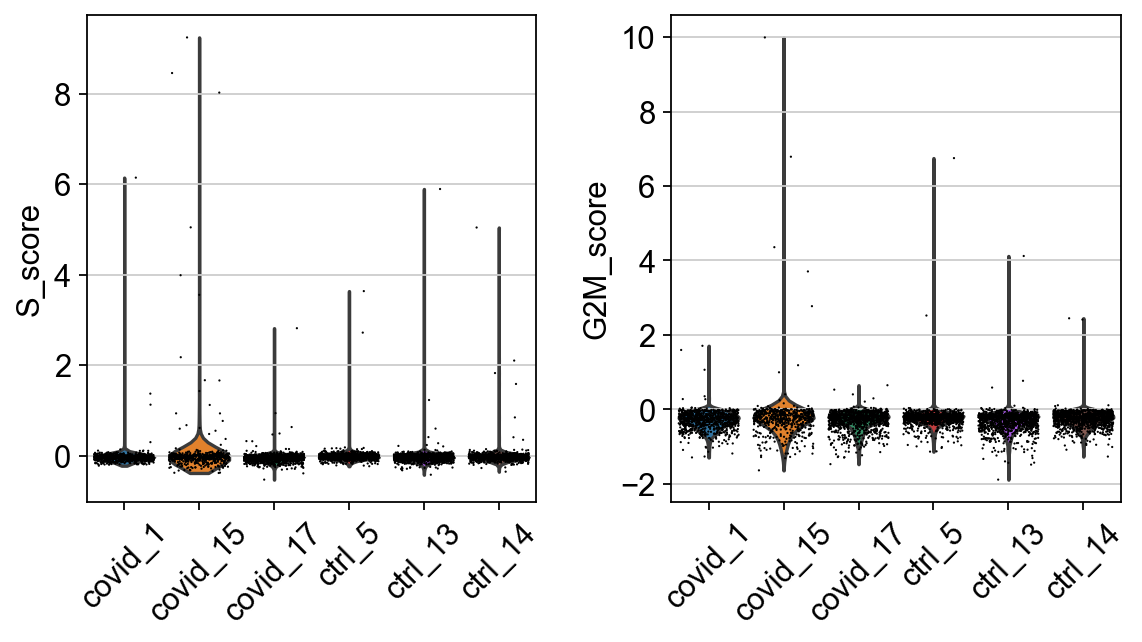

In [23]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'sample', rotation=45)

#CELLCYCLE_ALL3:

#DOUBLET_TITLE:

#DOUBLET_ALL1:

#DOUBLET_SCANPY1:

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 44.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 5.2 seconds


168

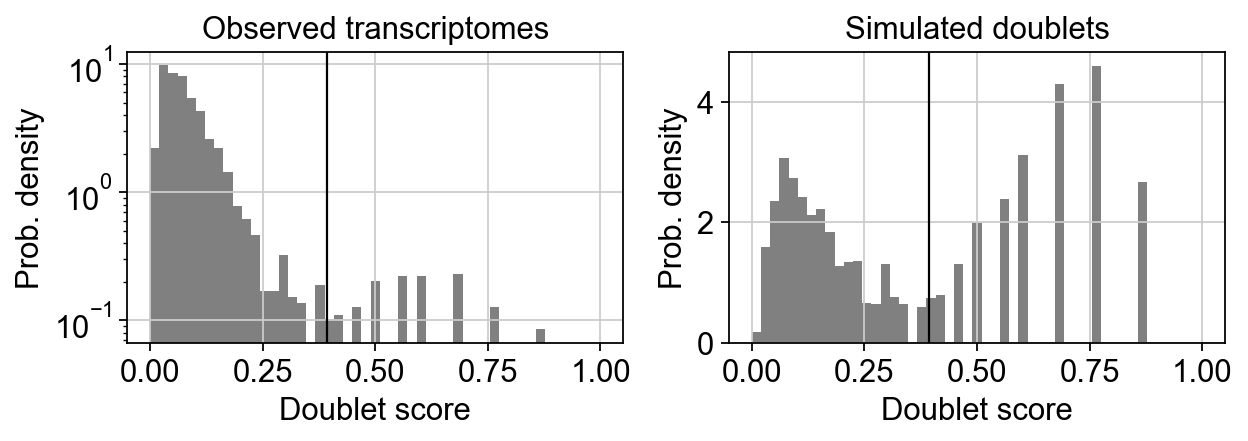

In [24]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])


In [25]:
# add in column with singlet/doublet instead of True/False

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

#DOUBLET_ALL1.1:

... storing 'doublet_info' as categorical
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


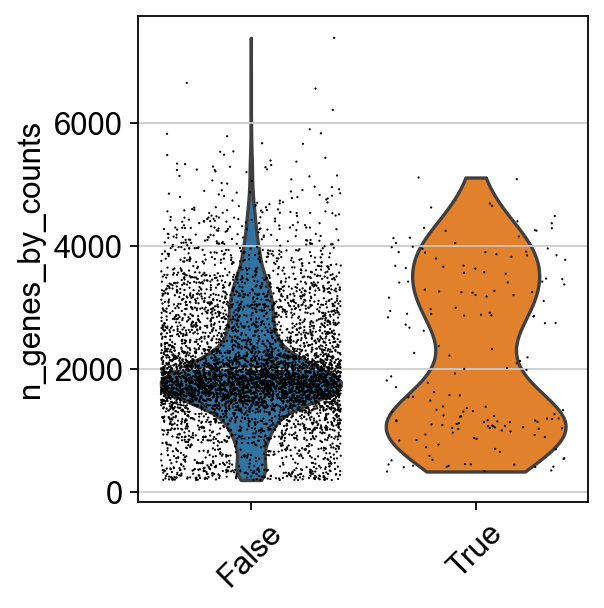

In [26]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

#DOUBLET_SCANPY1.3:

In [27]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

extracting highly variable genes


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


/Users/asbj/miniconda3/envs/scRNAseq2021/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:240: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values


    finished (0:00:13)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


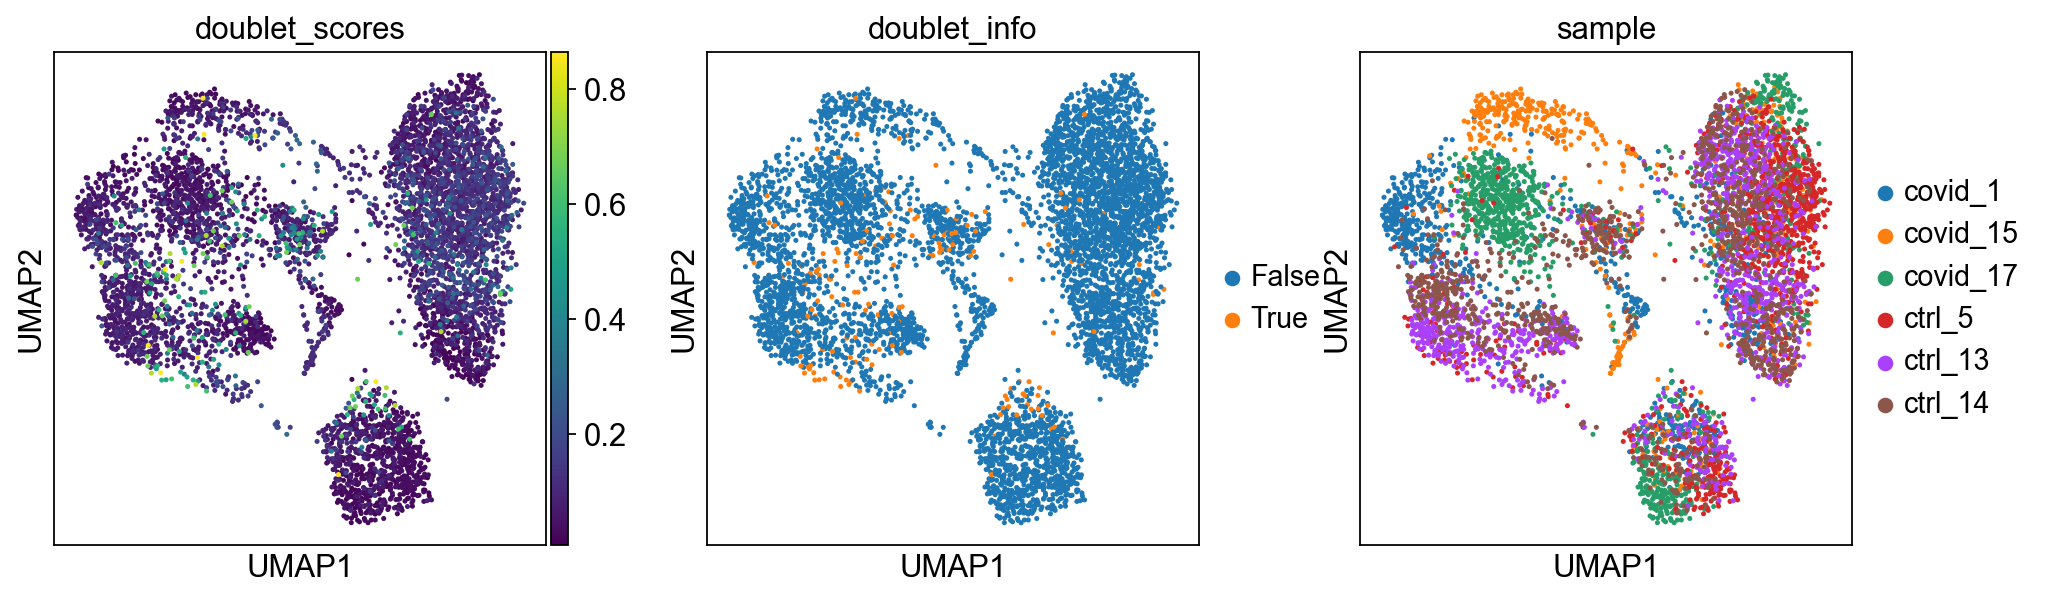

In [28]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info','sample'])


#DOUBLET_ALL2:

In [29]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)


(5594, 18752)


#DOUBLET_ALL3:

In [30]:
import os
os.makedirs('data/results/', exist_ok=True)

save_file = 'data/results/scanpy_qc_filtered_covid.h5ad'
adata.write_h5ad(save_file)